In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

<font color='red'> 
# Machine Learning: Unsupervised learning 

# (Part 2)
<font\>

### 2.5 Hierarchical clustering

Another interesting clustering technique is hierarchical clustering. Hierarchical clustering is a general family of clustering algorithms that build nested clusters by *merging or splitting* them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the *leaves* being the clusters with only one sample. This is a nice tool, because of its interpretability. The result of the technique is a *tree* showing the similarity among the samples. *Partitioning* is computed by selecting a cut on that tree at a certain level. The tree is usually called **dendrogram**.

<center><img src="images/clustering of genes.gif">
</center>

**Bottom-Up agglomerative clustering sketch of algorithm**

+ Starts with each sample data in a separate cluster.
+ Then, repeatedly joins the closest pair of clusters.
+ Until there is only one cluster.

The history of merging forms a binary tree or hierarchy.

**Top-Down divisive clustering sketch of algorithm**

+ Starting with all the data in a single cluster.
+ Consider every possible way to divide the cluster into two. Choose the best division.
+ Recursively operate on both sides.

The **AgglomerativeClustering** performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. 

** Defining the similarity of two clusters:**

The linkage criterion determines the metric used for the merge strategy:

+ *Maximum* or *complete* linkage minimizes the maximum distance between observations of pairs of clusters. Based on the similarity of the two least similar members, it will give tight spherical clusters.

+ *Average* linkage averages similarity between members i.e. minimizes the average of the distances between all observations of pairs of clusters.

+ *Single* linkage works on the similarity of two most similar members. It can create chain effects, such as follow the nearest neighbor.

+ *Ward* minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

AgglomerativeClustering can also *scale to large number* of samples when it is used jointly with a *connectivity matrix*, but is computationally expensive when no connectivity constraints are added between samples: it considers at each step all the possible merges.

<center>
<img src="images/plot_digits_linkage_002.png">
<img src="images/plot_digits_linkage_003.png">
<img src="images/plot_digits_linkage_001.png"> 
</center>

Agglomerative clustering has a ** “rich get richer” ** behavior that leads to *uneven cluster sizes*. In this regard, complete linkage is the worst strategy, and *Ward* gives the most regular sizes. 

However, the **affinity** cannot be varied with Ward, thus for non Euclidean metrics, *average linkage* is a good alternative.

 **Adding connectivity constraints**

An interesting aspect of Agglomerative Clustering is that connectivity constraints can be added to this algorithm (only adjacent points/clusters can be merged together).

This is achieved through a connectivity matrix that defines for each sample the neighboring samples following a given structure of the data. 

- For instance, in the swiss-roll example below, the connectivity constraints forbid the merging of points that are not adjacent on the swiss roll, and thus avoid forming clusters that extend across overlapping folds of the roll.

<center>
<img src="images/plot_ward_structured_vs_unstructured_0011.png">
<img src="images/plot_ward_structured_vs_unstructured_0021.png"> 
</center>

These constraints are useful to *impose a certain local structure*, but they also make the algorithm *faster*, especially when the number of the samples is high.
The connectivity constraints are imposed via a **connectivity matrix**: a scipy sparse matrix that has elements only at the intersection of a row and a column with indices of the dataset that should be connected. 

This matrix can be constructed from *a-priori information*: for instance, you may wish to cluster web pages by only merging pages with a *link pointing from one to another*. It can also be learned from the data, for instance using sklearn.neighbors.kneighbors_graph to restrict merging to nearest neighbors as in this example, or using sklearn.feature_extraction.image.grid_to_graph to enable only merging of neighboring pixels on an image.

[Agglomerative clustering with and without structure](http://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering.html#example-cluster-plot-agglomerative-clustering-py) 

This example shows the effect of imposing a connectivity graph to capture local structure in the data. The graph is simply the graph of 20 nearest neighbors.
Two consequences of imposing a connectivity can be seen. 

- First clustering with a connectivity matrix is much faster.

- Second, when using a connectivity matrix, average and complete linkage are unstable and tend to create a few clusters that grow very quickly. The connectivity graph breaks this mechanism. 

This effect is more pronounced for very sparse graphs (try decreasing the number of neighbors in kneighbors_graph) and with complete linkage.

- In particular, having a very small number of neighbors in the graph, imposes a geometry that is close to that of single linkage, which is well known to have this percolation instability.

In [23]:
# Authors: Gael Varoquaux, Nelle Varoquaux
# License: BSD 3 clause

import time
# import matplotlib.pyplot as plt
# import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)

X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

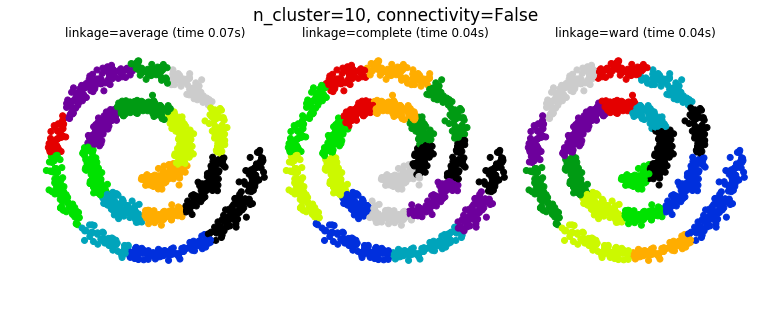

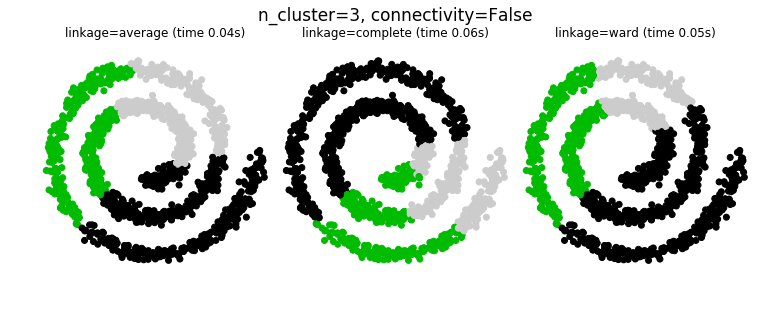

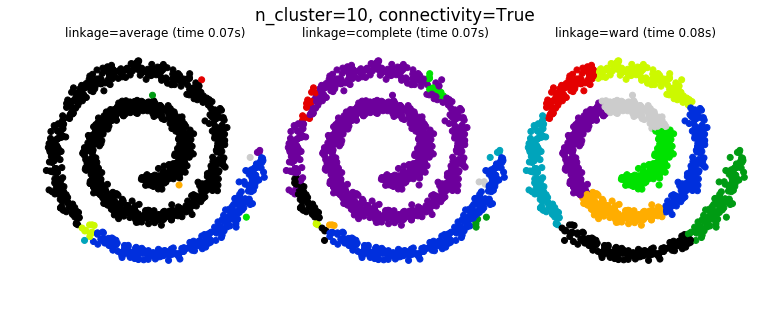

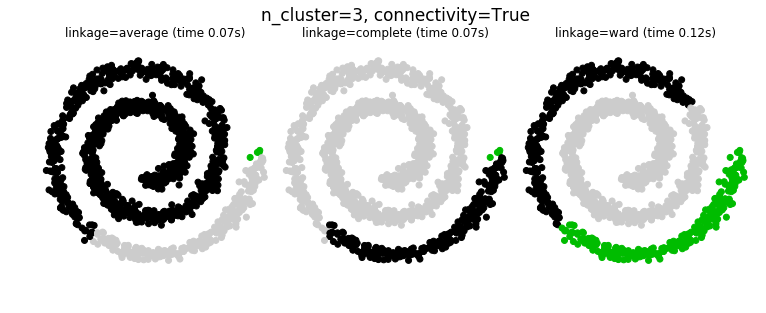

In [24]:
# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 15, include_self=True)

for connectivity in (None, knn_graph):
    for n_clusters in (10, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                                                          fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %(n_clusters, connectivity is not None), size=17)

plt.show()

### 2.6 Spectral clustering

Our last method in this notebook will be spectral clustering. In order to illustrate it, we will add some *spice* to our problem. But before it, let us check on the theoretical and algorithmic basis of the technique.

Up to this point, we have considered clustering as finding data groups following a notion of **compactness**. Another way of looking at what a cluster is, is given by the **connectivity** (or **similiarity**).

Let us check an example of the difference of both:

In [25]:
from sklearn.datasets.samples_generator import make_moons, make_blobs
import matplotlib.pyplot as plt

centres = [[1, 1], [0, 0], [0, 2]]

X, labels_true = make_blobs(n_samples=1000, centers=centres, cluster_std=0.2)

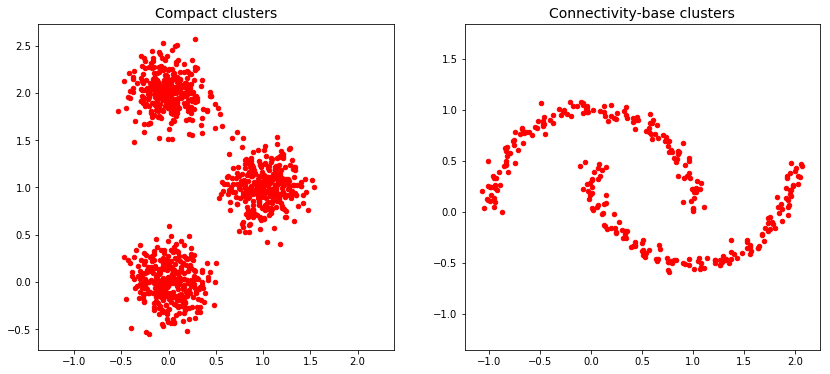

In [26]:
plt.subplot(1,2,1)
plt.scatter(X[:, 0], X[:, 1], c='r', marker='o',s=20) 
plt.axis('equal')
plt.title('Compact clusters',size=14)

[Xmoons, ymoons] = make_moons(n_samples=300, noise=.05)
plt.subplot(1,2,2)
plt.scatter(Xmoons[:, 0], Xmoons[:, 1], c='r', marker='o',s=20) 
plt.axis('equal')
plt.title('Connectivity-base clusters', size=14)
fig = plt.gcf()
fig.set_size_inches((14,6))

**Spectral clustering** refers to a family of methods that use spectral techniques. 

Specifically, these techniques are related to the *eigen-decomposition of an affinity or similarity* matrix.

They attempt to solve the problem of clustering according to *connectivity*.

Let us consider an ideal similarity matrix of two clear sets.

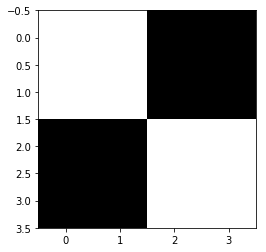

In [27]:
#Suppose an ideal similarity matrix
import numpy as np

S = np.array([[1,1,0,0],[1, 1, 0, 0],[0,0,1,1],[0,0,1,1]]) # connectivity matrix
plt.imshow(S,interpolation='nearest')

This matrix shows *how data is similar* to each other. We can clearly see two clusters. Let us now check the eigenvectors of this matrix.

Eigenvalues: 
 [ 2.  2.  0.  0.]

Eigenvectors: 
 [[ 0.70710678  0.         -0.70710678  0.        ]
 [ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.70710678  0.         -0.70710678]
 [ 0.          0.70710678  0.          0.70710678]]


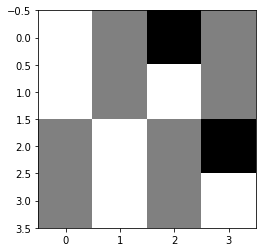

In [28]:
# Perform eigenvalue decomposition and show the eigenvectors in descending order
from scipy.linalg import eig
 
[eig_vals, eig_vecs] = eig(S)
 
sorted_inds = np.argsort(-eig_vals.real, axis=0)
 
print('Eigenvalues: \n', np.real(eig_vals[sorted_inds]))
print()
print('Eigenvectors: \n', eig_vecs[:,sorted_inds])
plt.imshow(np.real(eig_vecs[:,sorted_inds]),interpolation='nearest')

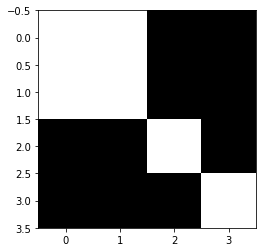

In [29]:
#Suppose an ideal similarity matrix
import numpy as np
 
S = np.array([[1,1,0,0],[1, 1, 0, 0],[0,0,1,0],[0,0,0,1]])
plt.imshow(S,interpolation='nearest')


[ 2.  1.  1.  0.]

[[ 0.70710678  0.          0.         -0.70710678]
 [ 0.70710678  0.          0.          0.70710678]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]]


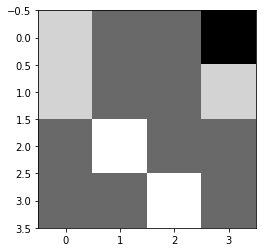

In [30]:
# Perform eigenvalue decomposition and show the eigenvectors in descending order
 
from scipy.linalg import eig
 
[eig_vals, eig_vecs] = eig(S)
sorted_inds = np.argsort(-eig_vals.real, axis=0)
 
print(np.real(eig_vals[sorted_inds]))
print()
print(eig_vecs[:,sorted_inds])
plt.imshow(np.real(eig_vecs[:,sorted_inds]),interpolation='nearest')


Observe that in the ideal case the first eigenvector characterizes the first cluster and the second one - the second cluster. This observation can be generalized to k-eigenvectors for K clusters. Let us corrupt the matrix a little bit, and see what happens.

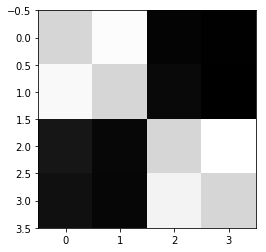

In [31]:
noise=0.2
S = np.array([[1,1,0,0],[1, 1, 0, 0],[0,0,1,1],[0,0,1,1]])
S2 = S+noise*np.random.rand(S.shape[0],S.shape[1])*(1-np.eye(4))

plt.imshow(S2,interpolation='nearest')


[ 2.3896626   1.92291599 -0.15628929 -0.15628929]

[[-0.45786138 -0.45811472  0.5445271   0.5445271 ]
 [-0.4583627  -0.45174931 -0.53823232 -0.53823232]
 [-0.54639557  0.54445832 -0.05747726 -0.05747726]
 [-0.53077158  0.53816224  0.03090804  0.03090804]]


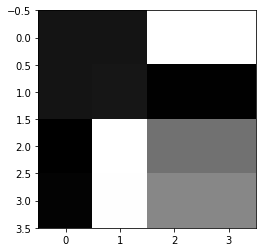

In [32]:
# Perform eigenvalue decomposition and show the eigenvectors in descending order
[eig_vals, eig_vecs] = eig(S2)

sorted_inds = np.argsort(-eig_vals.real, axis=0)
 
print(np.real(eig_vals[sorted_inds]))
 
print ()
 
print(np.real(eig_vecs[:,sorted_inds]))
 
plt.imshow(np.real(eig_vecs[:,sorted_inds]),interpolation='nearest')


The result is not so nice, but let us look at the first two eigenvectors. Can we observe the clusters?

<div class="alert alert-success"> **EXERCISE:** Increase the value of the random noise and check the two first eigenvalues and eigenvectors. Can we partition the two clusters based on that information? (Recall that the maximum value in a similarity matrix is 1.)
</div>

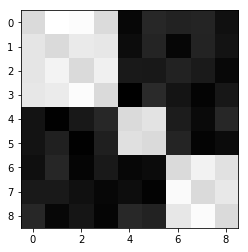

In [33]:
#Suppose an ideal similarity matrix
import numpy as np
 
S = np.array([[1,1,1,1,0,0,0,0,0],[1,1,1,1,0,0,0,0,0],[1,1,1,1,0,0,0,0,0],[1,1,1,1,0,0,0,0,0],[0,0,0,0,1,1,0,0,0],
              [0,0,0,0,1,1,0,0,0],[0,0,0,0,0,0,1,1,1],[0,0,0,0,0,0,1,1,1],[0,0,0,0,0,0,1,1,1]])
 
noise=0.2
S2 = S+noise*np.random.rand(S.shape[0],S.shape[1])*(1-np.eye(9))
plt.imshow(S2,interpolation='nearest')
 

Eigenvalues: 
 [  4.42524884e+00   3.10824102e+00   1.96981754e+00   1.89783718e-04
   1.89783718e-04  -9.29373089e-02  -9.29373089e-02  -1.41253162e-01
  -1.76559179e-01]

Eigenvectors: 
 [[ 0.48481159  0.15275543  0.06341949 -0.00875303 -0.00875303  0.05603808
   0.05603808  0.34035798 -0.44186368]
 [ 0.46553417  0.16382816  0.04814629  0.16818183  0.16818183  0.15783855
   0.15783855  0.28115684  0.40919037]
 [ 0.4758509   0.16302781  0.05318991  0.17847448  0.17847448 -0.31566527
  -0.31566527 -0.45105565  0.43463743]
 [ 0.47410236  0.18103528  0.05800809 -0.30024276 -0.30024276  0.14597041
   0.14597041 -0.1096011  -0.43590589]
 [ 0.1039498  -0.1038576  -0.69559426  0.48678215  0.48678215  0.15316791
   0.15316791  0.26161415 -0.00175238]
 [ 0.09964961 -0.08305032 -0.69134071 -0.44120874 -0.44120874 -0.17513325
  -0.17513325 -0.30507339  0.01931486]
 [ 0.15906215 -0.52676674  0.1092829  -0.35755887 -0.35755887 -0.37555962
  -0.37555962  0.0575768   0.02678044]
 [ 0.15681147 -0.541

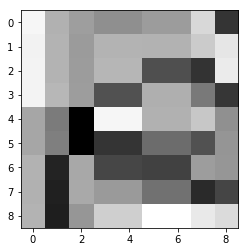

In [34]:
[eig_vals, eig_vecs] = eig(S2)
sorted_inds = np.argsort(-eig_vals.real, axis=0)
 
print('Eigenvalues: \n', np.real(eig_vals[sorted_inds]))
 
print ()
 
print('Eigenvectors: \n', np.real(eig_vecs[:,sorted_inds]))
 
plt.imshow(np.real(eig_vecs[:,sorted_inds]),interpolation='nearest')

#### 2.6.1 Setting the number of clusters

Let us look at the eigenvalues in ascending order.

[  4.42524884e+00+0.j           3.10824102e+00+0.j           1.96981754e+00+0.j
  -9.29373089e-02+0.11422433j  -9.29373089e-02-0.11422433j
   1.89783718e-04+0.03364927j   1.89783718e-04-0.03364927j
  -1.76559179e-01+0.j          -1.41253162e-01+0.j        ]


<Container object of 9 artists>

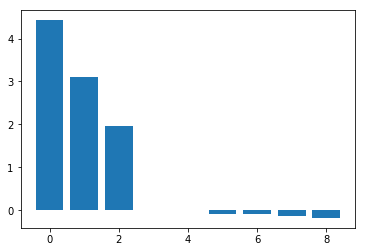

In [35]:
#Setting the clusters
# plt.bar(range(10), eig_vals.real[sorted_inds[0:10]])
print(eig_vals)
 
plt.bar(range(9), eig_vals.real[sorted_inds])

Observe that there are three which are very different from zero. In particular, a good heuristic for checking how many clusters there are is precisely counting the number of different from zero eigenvalues. In this problem, this value is precisely three clusters.

#### 2.6.2 Handling multiple clusters
What if we have multiple clusters? Actually, for $K$ clusters we have to check for the corresponding eigenvectors. The usual way of handling this situation is to use a K-means on the  eigenvectors of interest.

In [36]:
from sklearn.cluster import KMeans

K=3
clf = KMeans(n_clusters=K,init='k-means++')

In [37]:
print('Eigenvectors:\n', np.real(eig_vecs[:,sorted_inds[0:K]]))
print() 
    
print('Eigenvalues:\n', np.real(eig_vals))

Eigenvectors:
 [[ 0.48481159  0.15275543  0.06341949]
 [ 0.46553417  0.16382816  0.04814629]
 [ 0.4758509   0.16302781  0.05318991]
 [ 0.47410236  0.18103528  0.05800809]
 [ 0.1039498  -0.1038576  -0.69559426]
 [ 0.09964961 -0.08305032 -0.69134071]
 [ 0.15906215 -0.52676674  0.1092829 ]
 [ 0.15681147 -0.54137525  0.1146516 ]
 [ 0.16248792 -0.54974554  0.02397321]]

Eigenvalues:
 [  4.42524884e+00   3.10824102e+00   1.96981754e+00  -9.29373089e-02
  -9.29373089e-02   1.89783718e-04   1.89783718e-04  -1.76559179e-01
  -1.41253162e-01]


In [38]:
clf.fit(np.real(eig_vecs[:,sorted_inds[0:K]]))
y_pred=clf.predict(np.real(eig_vecs[:,sorted_inds[0:K]]))
print(y_pred)
 

[1 1 1 1 0 0 2 2 2]


The former code is now general for any number of clusters.

#### 2.6.3 A more complex example: Let us apply k-means to the two moons toy problem (OPTIONAL) 

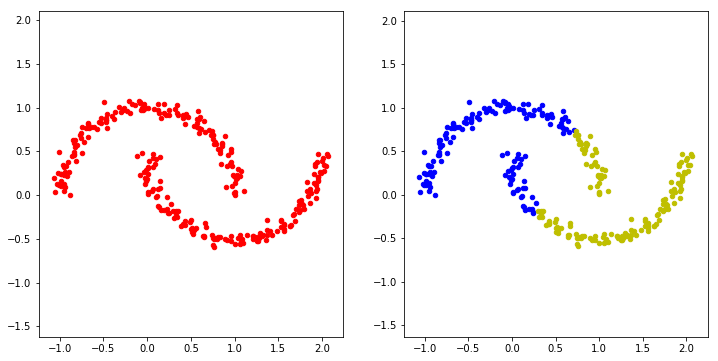

In [39]:
# %reset -f
from sklearn.datasets.samples_generator import make_moons
import matplotlib.pyplot as plt
from sklearn import cluster
 
# Connectivity based clustering dataset
plt.subplot(1,2,1)
plt.scatter(Xmoons[:, 0], Xmoons[:, 1], c='r', marker='o',s=20) 
plt.axis('equal')
 
# Cluster using k-means
clf = cluster.KMeans(n_clusters=2,init='k-means++')
clf.fit(Xmoons)
y_pred=clf.predict(Xmoons)
 
# Visualize k-means result
plt.subplot(1,2,2)
plt.scatter(Xmoons[y_pred==0, 0], Xmoons[y_pred==0, 1], c='b', marker='o',s=20) 
plt.scatter(Xmoons[y_pred==1, 0], Xmoons[y_pred==1, 1], c='y', marker='o',s=20) 
plt.axis('equal')
fig=plt.gcf()
fig.set_size_inches((12,6))

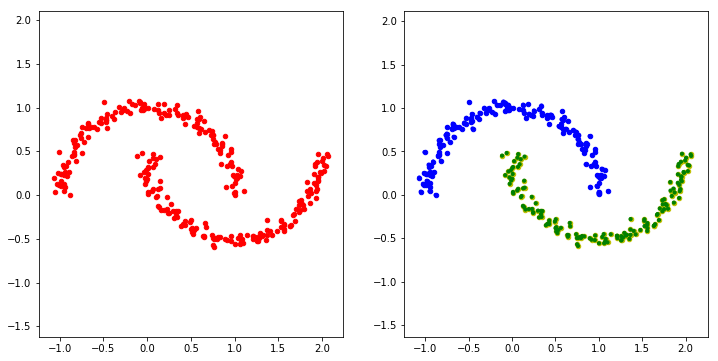

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import euclidean_distances
import time

import warnings
warnings.filterwarnings("ignore")

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
 
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(Xmoons)
 
# Compute distances
distances = euclidean_distances(Xmoons)
    
spectral = cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
 
t0 = time.time()
spectral.fit(Xmoons)
t1 = time.time()
 
y_pred = spectral.labels_.astype(np.int)
            
# Visualize spectral clustering results
plt.subplot(1,2,1)
plt.scatter(Xmoons[:, 0], Xmoons[:, 1], c='r', marker='o',s=20) 
plt.axis('equal')
 
plt.subplot(1,2,2)
plt.scatter(Xmoons[y_pred==0, 0], Xmoons[y_pred==0, 1], c='b', marker='o',s=20) 
plt.scatter(Xmoons[y_pred==1, 0], Xmoons[y_pred==1, 1], c='y', marker='o',s=20) 
plt.axis('equal')
fig=plt.gcf()
fig.set_size_inches((12,6))
plt.scatter(Xmoons[:, 0], Xmoons[:, 1], color=colors[y_pred].tolist(), s=10)


### 2.7 Refinement (OPTIONAL)

Usually, the **spectral clustering** partitions a set of points into two sets $(B_1,B_2)$ based on the eigenvectors of the Laplacian matrix defined as $L:=D-A$, instead of just the similarity matrix $A$. The method looks for the corresponding to the second-smallest eigenvalue of the Laplacian matrix, where $A$ is  where $A_{ij} >= 0$ represents a measure of the similarity between data points with indexes i and j, and $D$ is a diagonal matrix, $D_{ii}=\sum_j(A_{ij})$.

**Observations:**

+ Usually, the clustering is performed on the **graph Laplacian matrix** ($L = D - A$), where $D$ is the **degree matrix** (a diagonal matrix where each element $d_{i,j}$ counts the number of edges the node has) and the role of the similarity matrix is now given by the **affinity matrix** ($A$).
+ Because the Laplacian is related to $-A$, instead of computing the second larger eigenvector,  the second smaller eigenvector is checked.
+ Some more [examples](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#)

### (OPTIONAL) An informal intuition about why this works
In many areas in engineering, finance, ... we usually find problems in which our model is a linear system of equations, i.e. $Ax = b$. The matrix $A$ transforms vector $x$ into some desired right hand side $b$. We may be interested in the application of the model to new data (finding $b$) or in finding the values that satisfy several condition via the inverse problem $x = A^{-1} b$. However, sometimes we are interested in understanding the transformation itself. 

Eigendecomposition of a matrix allows us to better undertand the transformation. The application of a matrix to a vector geometrically rotates and scales the vector. Eigendecomposition characterizes the set of vectors that are only scaled by the transformation. This means that if a vector is close to one of the eigenvectors, it will be just approximately scaled by the eigenvalue. Because the eigenvectors are orthogonal, they form a basis of  the same space. This means that for instance projecting on this basis the elements of the new vector will be just scaled by their eigenvalue.

Why is this interesting? Consider for instance the covariance matrix. Checking the eigenvectors, we may know the direction that yields the maximum variance of the data i.e. the eigenvector with the maximum eigenvalue. In our case, considering the similarity matrix, we may find a direction that makes the values as similar as posible. 

### 2.8 Comparing different clustering algorithms on toy datasets

In [41]:
from sklearn import cluster, datasets
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

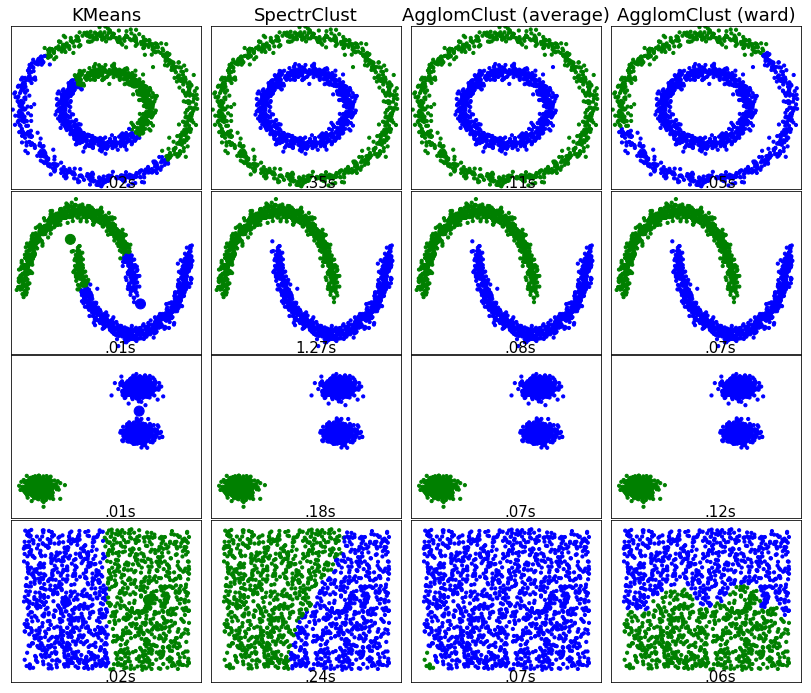

In [42]:
plt.figure(figsize=(11, 9.5))
plt.subplots_adjust(left=.001, right=.999, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
for i_dataset, dataset in enumerate([noisy_circles, noisy_moons, blobs, no_structure]):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=True)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Compute distances
    distances = euclidean_distances(X)

    # create clustering estimators
    means = cluster.KMeans(n_clusters=2)
    spectral = cluster.SpectralClustering(n_clusters=2, eigen_solver='arpack',
                                                  affinity="nearest_neighbors")
    average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock", 
                                                  n_clusters=2, connectivity=connectivity)
    ward = cluster.AgglomerativeClustering(n_clusters=2,
                                                  linkage='ward', connectivity=connectivity)

    for name, algorithm in [
                            ('KMeans', means),
                            ('SpectrClust', spectral),
                            ('AgglomClust (average)', average_linkage),
                            ('AgglomClust (ward)', ward)
                           ]:
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, 4, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            
        #visualize results    
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.66, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

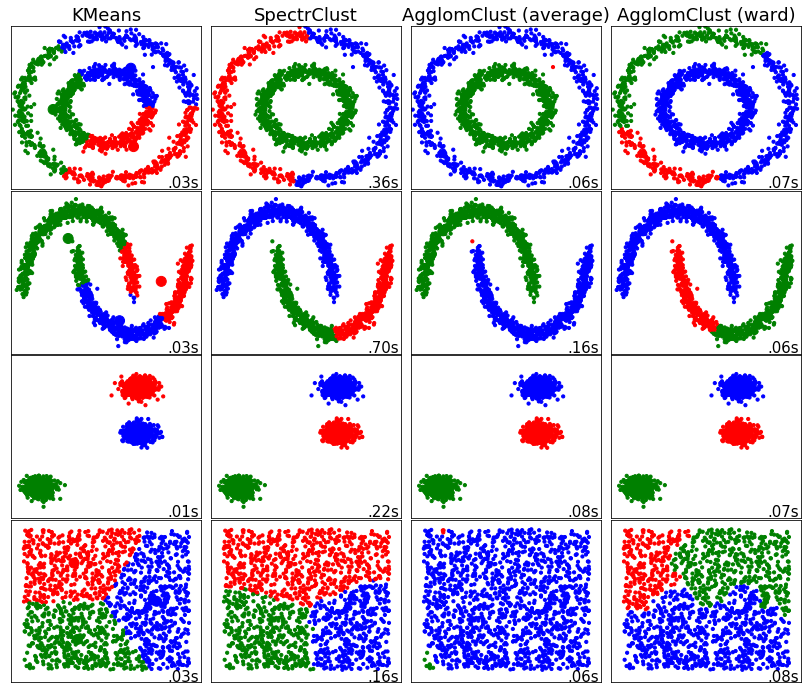

In [43]:
plt.figure(figsize=(11, 9.5))
plt.subplots_adjust(left=.001, right=.999, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1

for i_dataset, dataset in enumerate([noisy_circles, noisy_moons, blobs,
                                     no_structure]):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)


    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=True)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Compute distances
    distances = euclidean_distances(X)

    # create clustering estimators
 
    means = cluster.KMeans(n_clusters=3)
    spectral = cluster.SpectralClustering(n_clusters=3,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    average_linkage = cluster.AgglomerativeClustering(linkage="average",
                            affinity="cityblock", n_clusters=3,
                            connectivity=connectivity)
    ward = cluster.AgglomerativeClustering(n_clusters=3,
                    linkage='ward', connectivity=connectivity)

    for name, algorithm in [
                            ('KMeans', means),
                            ('SpectrClust', spectral),
                            ('AgglomClust (average)', average_linkage),
                            ('AgglomClust (ward)', ward)
                           ]:
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, 4, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


### 2.3.6.1 Summary table

In the following adapted table from sklearn documentation, we may check several methods for clustering, their corresponding parameters, scalability, their use and the notions of similarity they use as well as the input data format needed.

<table border="1">
<colgroup>
<col width="12.5%" />
<col width="12.5%" />
<col width="20%" />
<col width="20%" />
<col width="20%" />
<col width="15%" />
</colgroup>
<thead valign="bottom">
<tr class="row-odd"><th class="head">Method name</th>
<th class="head">Parameters</th>
<th class="head">Scalability</th>
<th class="head">Use</th>
<th class="head">Metric</th>
<th class="head">Input</th>
</tr>
</thead>
<tbody valign="top">
<tr class="row-even"><td><em>K-Means</em></td>
<td>number of clusters</td>
<td>Very large <cite>n_samples</cite>, medium <cite>n_clusters</cite></td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
<td>Data samples</td>
</tr>
<tr class="row-odd"><td><em>Spectral clustering</em></td>
<td>number of clusters</td>
<td>Medium <cite>n_samples</cite>, small <cite>n_clusters</cite></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
<td>Affinity/distance matrix</td>
</tr>
<tr class="row-even"><td><em>Hierarchical clustering</em></td>
<td>number of clusters/ threshold</td>
<td>Large <cite>n_samples</cite> and <cite>n_clusters</cite></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
<td>Data samples</td>
</tr>
</tbody>
</table>


<font color='red'> 

# 3. CASE STUDY: EUROSTAT data analysis


Eurostat is the home of the [European Commission data](http://ec.europa.eu/eurostat). Eurostat’s main role is to process and publish comparable statistical information at European level. Data in Eurostat is provided by each member state. Eurostat's re-use policy is free re-use of its data, both for non-commercial and commercial purposes (with some minor exceptions).

## 3.1 Applying K-means to cluster countries according to their education resourses

In this case study, we are going to retrieve Eurostat data and test clustering algorithms on it. The amount of data in the database is huge, thus we are going to use a small subset for illustration purposes. In our first study, we are going to focus on **indicators on education finance data** among the member states. The data is already downloaded and provided as is in the file `educ_figdp_1_Data.csv`. You can download it directly following this link: `Database by terms>Population and social conditions>Education and training>Indicators on education finance`. 

Let us start having a look at the data.

In [44]:
%reset -f
#Read and check the dataset downloaded from the EuroStat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
edu=pd.read_csv('./files/education_GDP/educ_figdp_1_Data.csv',na_values=':')
edu.head()

,TIME,GEO,INDIC_ED,Value
0,2002,European Union (27 countries),Total public expenditure on education as % of ...,5.10
1,2002,European Union (27 countries),Total public expenditure on education as % of ...,1.14
2,2002,European Union (27 countries),Total public expenditure on education as % of ...,2.32
3,2002,European Union (27 countries),Total public expenditure on education as % of ...,1.15
4,2002,European Union (27 countries),Total public expenditure on education as % of ...,0.50


In [45]:
edu.tail()

,TIME,GEO,INDIC_ED,Value
4915,2011,Japan,Total public expenditure on education as % of ...,NaN
4916,2011,Japan,Expenditure on educational institutions from p...,NaN
4917,2011,Japan,Public subsidies to the private sector as % of...,NaN
4918,2011,Japan,Expenditure on educational institutions from p...,1.56
4919,2011,Japan,Total public expenditure on education as % of ...,3.67


Data in CSV and databases are often organized in what is called **stacked** or **record** formats. In our case for each year (`TIME`) and country (`GEO`) of the EU as well as some reference countries such as Japan and United States, we have twelve indicators (`INDIC_ED`) on education finance with their values (`Value`). Let us reshape the table into a feature vector style data set. 

To the process of reshaping stacked data into a table is sometimes called **pivoting**.

In [46]:
#Pivot table in order to get a nice feature vector representation with dual indexing by TIME and GEO 
pivedu=pd.pivot_table(edu, values='Value', index=['TIME', 'GEO'], columns=['INDIC_ED'])

pivedu.head()


INDIC_ED       Expenditure on educational institutions from private sources as % of GDP, for all levels of education combined  \
TIME GEO                                                                                                                        
2002 Albania                                                 NaN                                                                
     Austria                                                0.38                                                                
     Belgium                                                0.36                                                                
     Bulgaria                                               0.67                                                                
     Croatia                                                0.13                                                                

INDIC_ED       Expenditure on educational institutions from public sources as % of GDP, for all levels of government combined  \
TIME GEO                                                                                                                        
2002 Albania                                                 NaN                                                                
     Austria                                                5.30                                                                
     Belgium                                                5.80                                                                
     Bulgaria                                               3.75                                                                
     Croatia                                                3.71                                                                

INDIC_ED       Expenditure on educational institutions from public sources as % of total public expenditure, for all levels of education combined  \
TIME GEO                                                                                                                                            
2002 Albania                                                 NaN                                                                                    
     Austria                                               10.46                                                                                    
     Belgium                                               11.65                                                                                    
     Bulgaria                                               9.49                                                                                    
     Croatia                                                 NaN                                                                                    

INDIC_ED       Public subsidies to the private sector as % of GDP, for all levels of education combined  \
TIME GEO                                                                                                  
2002 Albania                                                 NaN                                          
     Austria                                                0.37                                          
     Belgium                                                0.29                                          
     Bulgaria                                               0.18                                          
     Croatia                                                 NaN                                          

INDIC_ED       Public subsidies to the private sector as % of total public expenditure, for all levels of education combined  \
TIME GEO                                                                                                                       
2002 Albania                                                 NaN                                                               
     Austria  

In [47]:
print('Let us check the two indices:\n')
print('\nPrimary index (TIME): \n' + str(pivedu.index.levels[0].tolist()))
print('\nSecondary index (GEO): \n' + str(pivedu.index.levels[1].tolist()))

Let us check the two indices:


Primary index (TIME): 
[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]

Secondary index (GEO): 
['Albania', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Euro area (13 countries)', 'Euro area (15 countries)', 'European Union (25 countries)', 'European Union (27 countries)', 'Finland', 'Former Yugoslav Republic of Macedonia, the', 'France', 'Germany (until 1990 former territory of the FRG)', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Japan', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']


Observe that we have ten years information on these indicators, and as expected we have all members of the European Union with some aggregates and control/reference countries. For the sake of simplicity, let us focus on values on year 2010.

In [48]:
#Extract 2010 set of values
edu2010=pivedu.ix[2010]
edu2010.head()


INDIC_ED,"Expenditure on educational institutions from private sources as % of GDP, for all levels of education combined","Expenditure on educational institutions from public sources as % of GDP, for all levels of government combined","Expenditure on educational institutions from public sources as % of total public expenditure, for all levels of education combined","Public subsidies to the private sector as % of GDP, for all levels of education combined","Public subsidies to the private sector as % of total public expenditure, for all levels of education combined","Total public expenditure on education as % of GDP, at pre-primary level of education (ISCED 0) and not allocated by level","Total public expenditure on education as % of GDP, at primary level of education (ISCED 1)","Total public expenditure on education as % of GDP, at secondary level of education (ISCED 2-4)","Total public expenditure on education as % of GDP, at tertiary level of education (ISCED 5-6)","Total public expenditure on education as % of GDP, for all levels of education combined","Total public expenditure on education as % of gross national income, for all levels of education combined","Total public expenditure on education as % of total public expenditure, for all levels of education combined"
GEO,,,,,,,,,,,,
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Austria,0.52,5.25,9.98,0.64,1.22,0.61,1.01,2.64,1.63,5.89,5.90,11.20
Belgium,0.34,6.25,11.90,0.32,0.61,0.78,1.54,2.79,1.46,6.57,6.44,12.51
Bulgaria,0.63,3.35,8.96,0.74,1.99,0.92,0.80,1.76,0.61,4.10,4.18,10.95
Croatia,0.26,4.24,NaN,0.03,NaN,0.65,1.87,0.97,0.78,4.27,4.42,NaN


Let us clean and store the names of the features and the countries.

In [49]:
#Store column names and clear them for better handling. Do the same with countries
edu2010 = edu2010.rename(index={'Euro area (13 countries)': 'EU13',
                                'Euro area (15 countries)': 'EU15',
                                'European Union (25 countries)': 'EU25',
                                'European Union (27 countries)': 'EU27',
                                'Former Yugoslav Republic of Macedonia, the': 'Macedonia',
                                'Germany (until 1990 former territory of the FRG)': 'Germany'
                        })
features = edu2010.columns.tolist()
countries = edu2010.index.tolist()

edu2010.columns=range(12)
edu2010.head()

,0,1,2,3,4,5,6,7,8,9,10,11
GEO,,,,,,,,,,,,
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Austria,0.52,5.25,9.98,0.64,1.22,0.61,1.01,2.64,1.63,5.89,5.90,11.20
Belgium,0.34,6.25,11.90,0.32,0.61,0.78,1.54,2.79,1.46,6.57,6.44,12.51
Bulgaria,0.63,3.35,8.96,0.74,1.99,0.92,0.80,1.76,0.61,4.10,4.18,10.95
Croatia,0.26,4.24,NaN,0.03,NaN,0.65,1.87,0.97,0.78,4.27,4.42,NaN


As we can observe, this is not a clean data set, there are missing values. Some countries may not collect or have access to some indicators and there are countries without any indicators. Let us display this effect.

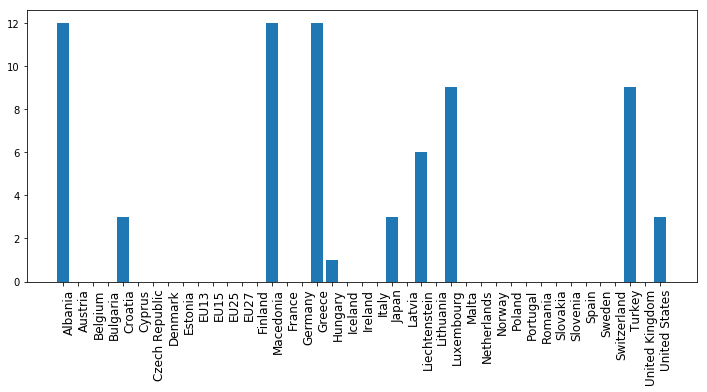

In [50]:
#Check what is going on in the NaN data 
nan_countries=np.sum(np.where(edu2010.isnull(),1,0),axis=1)

plt.bar(np.arange(nan_countries.shape[0]),nan_countries)
plt.xticks(np.arange(nan_countries.shape[0]),countries,rotation=90,horizontalalignment='left',fontsize=12)

fig = plt.gcf()
fig.set_size_inches((12,5))

We don't have info on Albania, Macedonia and Greece. And very limited info from Liechtenstein, Luxembourg and Turkey. So let us work without them. Now let us check the features.

[1 0 3 0 3 0 0 0 0 0 0 3]


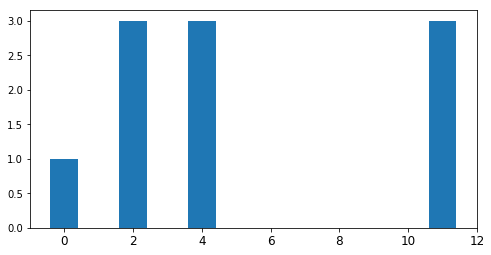

In [51]:
#Remove non info countries
wrk_countries = nan_countries<4

educlean=edu2010.ix[wrk_countries] #.ix - Construct an open mesh from multiple sequences.

#Let us check the features we have
na_features = np.sum(np.where(educlean.isnull(),1,0),axis=0)
print(na_features)

plt.bar(np.arange(na_features.shape[0]),na_features)
plt.xticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches((8,4))

There are four features with missing data. At this point we can proceed in two ways:

+ **Drop** the features with missing values.
+ **Fill in** the features with some non-informative, non-biasing data.

If we have many features and only a few have missing values then it is not much harmful to drop them. However, if missing values are spread across the features, we have to eventually deal with them. In our case, both options seem reasonable, so we will proceed with both at the same time.

In [52]:
#Options A: drop those features
edudrop=educlean.dropna(axis=1) 
         #dropna: Return object with labels on given axis omitted where alternately any or 
          # all of the data are missing
print('Drop data shape: ' + str(edudrop.shape))

Drop data shape: (35, 8)


In [53]:
#Option B fill those features with some value, at risk of extracting wrong information
#Constant filling : edufill0=educlean.fillna(0)
edufill=educlean.fillna(educlean.mean())
print('Filled in data shape: ' + str(edufill.shape))

Filled in data shape: (35, 12)


In the fill-in option, we have decided to fill the data with the mean value of the feature. This will not bias the distribution of the feature, though it has consequences in the interpretation of the results. 

Let us now apply a k-means clustering technique on this data in order to partition the countries according to their investment in education and check their profiles.

In [54]:
#Now we have clean data, create the data set to analyze
X_train = edudrop.values

from sklearn import cluster
clf = cluster.KMeans(init='k-means++', n_clusters=3, random_state=42)
    #‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to 
    # speed up convergence.
    
clf.fit(X_train) #Compute k-means clustering.

y_pred_drop = clf.predict(X_train) #Predict the closest cluster each sample in X belongs to.
print(y_pred_drop)

[2 1 0 0 1 0 1 2 2 2 2 2 1 2 2 2 1 1 0 0 2 2 1 2 1 2 2 0 0 2 2 1 2 2 2]


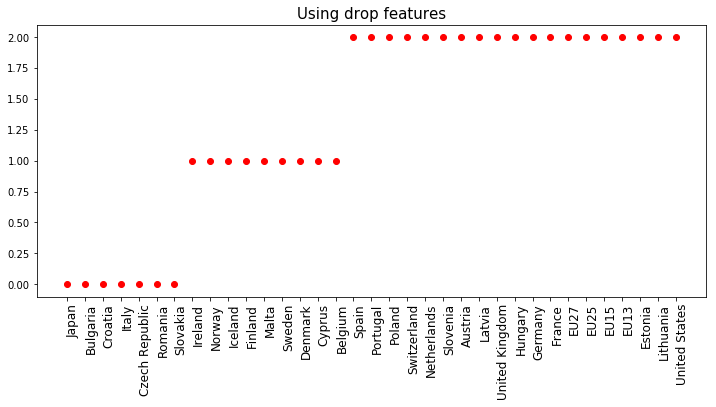

In [55]:
idx=y_pred_drop.argsort()
plt.plot(np.arange(35),y_pred_drop[idx],'ro')

wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]
plt.xticks(np.arange(len(wrk_countries_names)),[wrk_countries_names[i] for i in idx],rotation=90,
           horizontalalignment='left',fontsize=12)
plt.title('Using drop features',size=15)
fig = plt.gcf()
fig.set_size_inches((12,5))


[2 2 0 0 1 0 1 1 2 2 2 2 2 2 0 0 1 2 0 0 2 2 1 2 1 2 2 0 0 2 2 1 1 2 2]


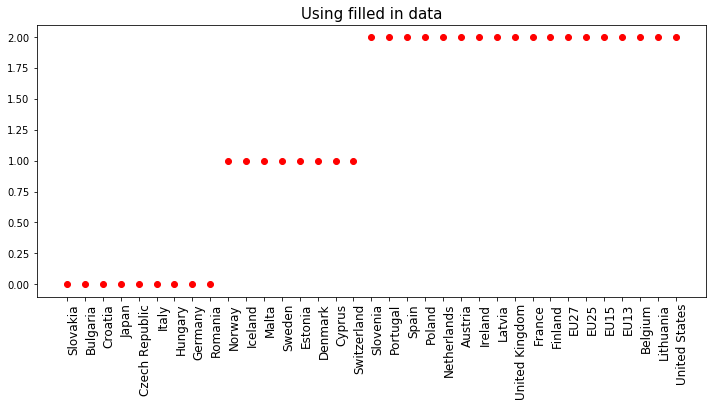

In [56]:
X_train = edufill.values
clf.fit(X_train) #Compute k-means clustering.

y_pred_fill = clf.predict(X_train) #Predict the closest cluster each sample in X belongs to.
print(y_pred_fill)

idx=y_pred_fill.argsort()
plt.plot(np.arange(35),y_pred_fill[idx],'ro')

wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]
plt.xticks(np.arange(len(wrk_countries_names)),[wrk_countries_names[i] for i in idx],rotation=90,
           horizontalalignment='left',fontsize=12)
plt.title('Using filled in data', size=15)
fig = plt.gcf()
fig.set_size_inches((12,5))

We have sorted the data for better visualization. At a simple glance we can see that both partitions can be different. We can better check this effect plotting the clusters values of one technique against the other.

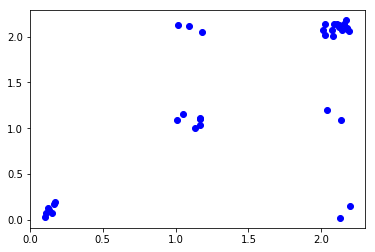

In [57]:
plt.plot(y_pred_drop+0.2*np.random.rand(35),y_pred_fill+0.2*np.random.rand(35),'bo')

Well, looking at both methods, both may yield the same results, but not necessarily always. This is mainly due to two aspects: the random initialization of the k-means clustering and the fact that each method works in a different space (dropped data vs filled-in data). 

Let us check the list of countries in both methods. Do not consider the cluster value, since it is irrelevant.

In [58]:
print('Cluster 0: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==0]))
print('Cluster 0: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_fill) if item==0]))
print('\n')
print('Cluster 1: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==1]))
print('Cluster 1: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_fill) if item==1]))
print('\n')
print('Cluster 2: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==2]))
print('Cluster 2: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_fill) if item==2]))
print('\n')


Cluster 0: 
['Bulgaria', 'Croatia', 'Czech Republic', 'Italy', 'Japan', 'Romania', 'Slovakia']
Cluster 0: 
['Bulgaria', 'Croatia', 'Czech Republic', 'Germany', 'Hungary', 'Italy', 'Japan', 'Romania', 'Slovakia']


Cluster 1: 
['Belgium', 'Cyprus', 'Denmark', 'Finland', 'Iceland', 'Ireland', 'Malta', 'Norway', 'Sweden']
Cluster 1: 
['Cyprus', 'Denmark', 'Estonia', 'Iceland', 'Malta', 'Norway', 'Sweden', 'Switzerland']


Cluster 2: 
['Austria', 'Estonia', 'EU13', 'EU15', 'EU25', 'EU27', 'France', 'Germany', 'Hungary', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'Switzerland', 'United Kingdom', 'United States']
Cluster 2: 
['Austria', 'Belgium', 'EU13', 'EU15', 'EU25', 'EU27', 'Finland', 'France', 'Ireland', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'United Kingdom', 'United States']




## 3.1.1 Shell we consider a data normalization?

We have been a little careless and proceeded with the clustering of data, without any normalization. Let us go into a little more detail in the data. For the sake of simplicity, let us work just with the drop set.

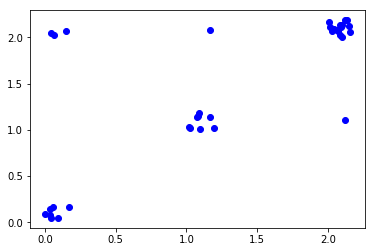

In [59]:
from sklearn.preprocessing import StandardScaler

y_pred_drop_unnorm=y_pred_drop.copy()

X_train = edudrop.values

scaler = StandardScaler() #Standardize features by removing the mean and scaling to unit variance

X_train = scaler.fit_transform(X_train)

clf.fit(X_train)
y_pred_drop = clf.predict(X_train)

plt.plot(y_pred_drop+0.2*np.random.rand(35),y_pred_drop_unnorm+0.2*np.random.rand(35),'bo')

**QUIZ:** In this case it seems both clustering techniques yield almost the same clusters. Why do you think both yield almost the same results? 

 Let us now check the clusters:

In [60]:
print('Cluster 0: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==0]))

print('Cluster 1: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==1]))

print('Cluster 2: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==2]))

Cluster 0: 
['Bulgaria', 'Croatia', 'Czech Republic', 'Hungary', 'Italy', 'Japan', 'Latvia', 'Romania', 'Slovakia', 'Spain']
Cluster 1: 
['Cyprus', 'Denmark', 'Finland', 'Iceland', 'Ireland', 'Malta', 'Norway', 'Sweden', 'United Kingdom']
Cluster 2: 
['Austria', 'Belgium', 'Estonia', 'EU13', 'EU15', 'EU25', 'EU27', 'France', 'Germany', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Switzerland', 'United States']


And check the profile of the clusters by looking at the centroids:

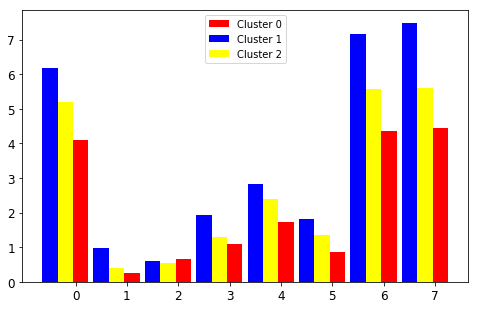

In [61]:
width=0.3
p1 = plt.bar(np.arange(8),scaler.inverse_transform(clf.cluster_centers_[1]),width,color='b')
        # Scale back the data to the original representation
    
p2 = plt.bar(np.arange(8)+width,scaler.inverse_transform(clf.cluster_centers_[2]),width,color='yellow')
p0 = plt.bar(np.arange(8)+2*width,scaler.inverse_transform(clf.cluster_centers_[0]),width,color='r')

plt.legend( (p0[0], p1[0], p2[0]), ('Cluster 0', 'Cluster 1', 'Cluster 2') ,loc=9)
plt.xticks(np.arange(8) + 0.5, np.arange(8),size=12)
plt.yticks(size=12)
fig = plt.gcf()
fig.set_size_inches((8,5))

It looks like cluster `1` spends more on education while cluster `0` is the one with less resources on education. (What about Spain?)

Let us refine a little bit more cluster `0` and check how close are members from this cluster to cluster `1`. This may give us a hint on a possible ordering. 

([<matplotlib.axis.XTick at 0xbdc6b00>,
 <a list of 10 Text xticklabel objects>)

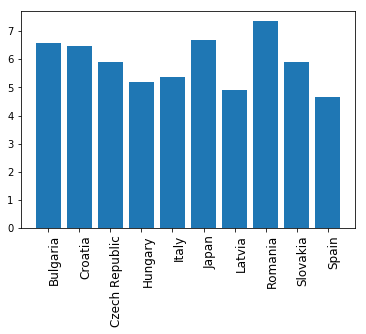

In [62]:
from scipy.spatial import distance

p = distance.cdist(X_train[y_pred_drop==0,:],[clf.cluster_centers_[1]],'euclidean') 
                              #the distance of the elements of cluster 0 to the center of cluster 1

plt.bar(np.arange(p.shape[0]),p)

wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]
zero_countries_names = [wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==0]
plt.xticks(np.arange(len(zero_countries_names)),zero_countries_names,rotation=90,horizontalalignment='left',fontsize=12)

Well, it seems that Spain belongs to cluster `0`, it is the closest to change to a policy in the lines of the other clusters.

Additionally, we can also check the distance to the centroid of cluster `0`.

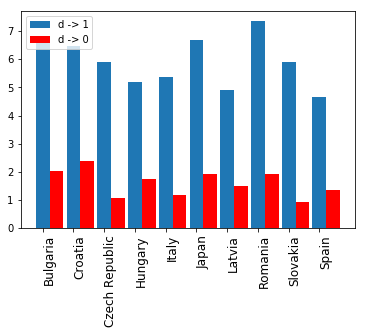

In [63]:
from scipy.spatial import distance

p = distance.cdist(X_train[y_pred_drop==0,:],[clf.cluster_centers_[1]],'euclidean')
pown = distance.cdist(X_train[y_pred_drop==0,:],[clf.cluster_centers_[0]],'euclidean')

width=0.45
p0=plt.bar(np.arange(p.shape[0]),p,width)
p1=plt.bar(np.arange(p.shape[0])+width,pown,width,color = 'red')

wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]
zero_countries_names = [wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==0]
plt.xticks(np.arange(len(zero_countries_names)),zero_countries_names,rotation=90,horizontalalignment='left',fontsize=12)
plt.legend( (p0[0], p1[0]), ('d -> 1', 'd -> 0') ,loc=2)


### 3.1.2 The number of clusters
The number of cluster has been arbitrarely chosen. We will explore the **elbow/knee technique** for looking for a "good" number $K$. Other references for finding the number of clusters are the GAP statistic or $f(K)$ (Pham et al. 2004) among others.

#### The elbow technique (Optional)

By the definition of clustering, we want clusters to be compact. The notion of compactness can be measured by checking the distance of the members of the cluster to its centroid. The average distance to its centroid is a naive measure of the overall quality of the cluster. The elbow technique distinguish two phases in the process of checking this value against the number of clusters. In the first phase, the average will decrease dramatically. In the second phase, it will slowly stabilize. The elbow technique consists of selecting the value, where this transition occurs. This can not always be easily found. 

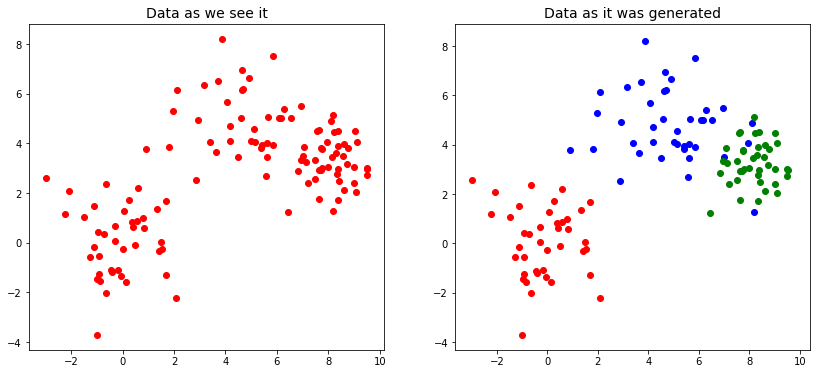

In [64]:
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN=40
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,3]+1*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
y = np.concatenate([y,3*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

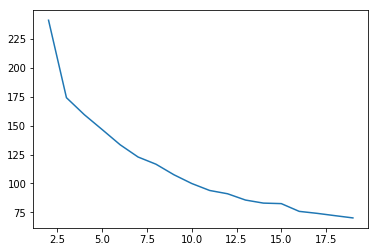

In [66]:
from sklearn import cluster
d=[]
iter=20
for K in range(2,iter):
    clf = cluster.KMeans(init='random', n_clusters=K, random_state=0)
    clf.fit(X)
    y_pred = clf.predict(X)
    p=[]
    for i in range(K):
        p.append(np.sum(distance.cdist(X[y_pred==i,:],[clf.cluster_centers_[i]],'euclidean')))
    d.append(np.sum(p))
plt.plot(np.arange(2,iter),d)

Checking at this graph it seems that $3$ is a good number of clusters. 

What about the case of the Eurostat data?

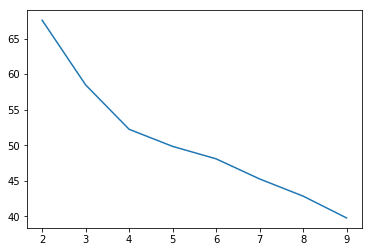

In [69]:
from sklearn import cluster
d=[]
for K in range(2,10):
    clf = cluster.KMeans(init='random', n_clusters=K, random_state=0)
    clf.fit(X_train)
    y_pred = clf.predict(X_train)
    p=[]
    for i in range(K):
        p.append(np.sum(distance.cdist(X_train[y_pred==i,:],[clf.cluster_centers_[i]],'euclidean')))
    d.append(np.sum(p))
plt.plot(np.arange(2,10),d)


It looks like $4$ can be a better choice. 

Let us redo the clustering with $K=4$ and see what we can conclude.

In [70]:
X_train = edudrop.values
clf = cluster.KMeans(init='k-means++', n_clusters=4, random_state=0)
clf.fit(X_train)
y_pred = clf.predict(X_train)

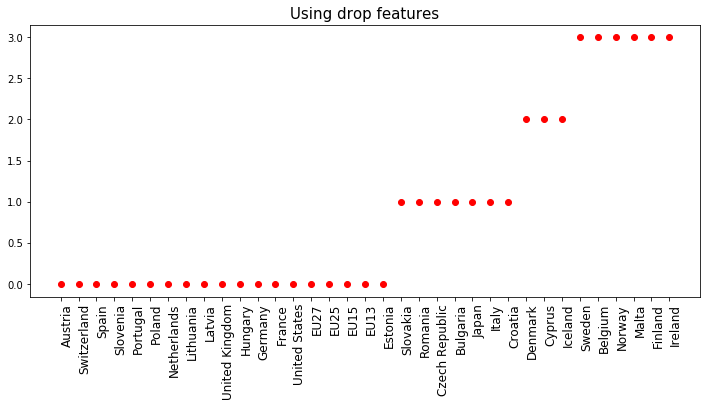

In [71]:
idx=y_pred.argsort()
plt.plot(np.arange(35),y_pred[idx],'ro')
wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]

plt.xticks(np.arange(len(wrk_countries_names)),[wrk_countries_names[i] for i in idx],rotation=90,horizontalalignment='left',fontsize=12)
plt.title('Using drop features',size=15)
fig = plt.gcf()
fig.set_size_inches((12,5))

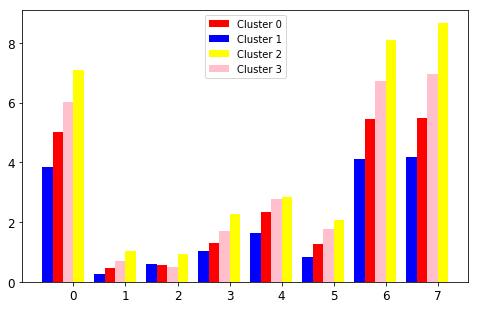

In [72]:
width=0.2
p0 = plt.bar(np.arange(8)+1*width,clf.cluster_centers_[0],width,color='r')
p1 = plt.bar(np.arange(8),clf.cluster_centers_[1],width,color='b')
p2 = plt.bar(np.arange(8)+3*width,clf.cluster_centers_[2],width,color='yellow')
p3 = plt.bar(np.arange(8)+2*width,clf.cluster_centers_[3],width,color='pink')

plt.legend( (p0[0], p1[0], p2[0], p3[0]), ('Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3') ,loc=9)
plt.xticks(np.arange(8) + 0.5, np.arange(8),size=12)
plt.yticks(size=12)
fig = plt.gcf()
fig.set_size_inches((8,5))

Spain is still in cluster `0`. But as we observed in our previous clustering it was very close to changing cluster. This time cluster `0` includes the averages values for the EU members. Just for the sake of completeness, let us write down the name of the countries in the clusters.

In [73]:
print('Cluster 0: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred) if item==0]))

print('Cluster 1: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred) if item==1]))

print('Cluster 2: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred) if item==2]))

print('Cluster 3: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred) if item==3]))

#Save data for future use.
import pickle
ofname = open('edu2010.pkl', 'wb')
s = pickle.dump([edu2010, wrk_countries_names,y_pred ],ofname)
ofname.close()

Cluster 0: 
['Austria', 'Estonia', 'EU13', 'EU15', 'EU25', 'EU27', 'France', 'Germany', 'Hungary', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'Switzerland', 'United Kingdom', 'United States']
Cluster 1: 
['Bulgaria', 'Croatia', 'Czech Republic', 'Italy', 'Japan', 'Romania', 'Slovakia']
Cluster 2: 
['Cyprus', 'Denmark', 'Iceland']
Cluster 3: 
['Belgium', 'Finland', 'Ireland', 'Malta', 'Norway', 'Sweden']


<div class="alert alert-info">TAKE HOME NOTES:
<p>
<ul>
<li>K-means is a simple, but quite powerful clustering partition technique.
<li>It is very sensitive to variance differences on the features / features at different scales.
<li>It is resistant to irrelevant dimensions as far as they do not introduce biases.
</ul>
</div>

We can repeat the process using the alternative clustering techniques and compare their results. Let us first apply the **spectral clustering**. The corresponding code will be:

In [74]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import euclidean_distances

X = StandardScaler().fit_transform(edudrop.values)
 
distances = euclidean_distances(edudrop.values)
    
spectral = cluster.SpectralClustering(n_clusters=4, affinity="nearest_neighbors")
spectral.fit(edudrop.values)
 
y_pred = spectral.labels_.astype(np.int)

If we visualize the results:

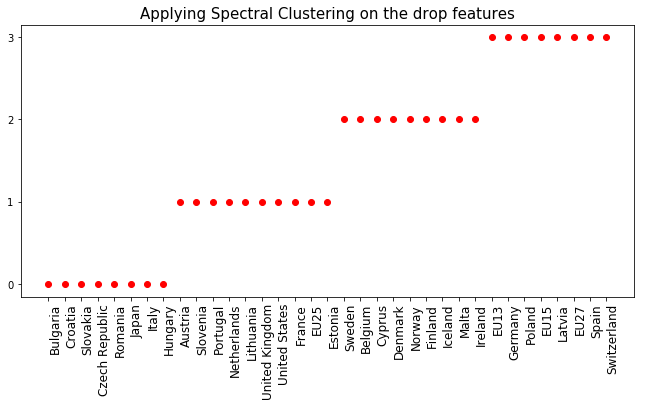

In [75]:
idx=y_pred.argsort()

plt.plot(np.arange(35),y_pred[idx],'ro')
wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]

plt.xticks(np.arange(len(wrk_countries_names)),[wrk_countries_names[i] 
        for i in idx],rotation=90,horizontalalignment='left',fontsize=12)

plt.yticks([0,1,2,3])

plt.title('Applying Spectral Clustering on the drop features',size=15)
fig = plt.gcf()
fig.set_size_inches((11,5))

Note that in general, the spectral clustering intends to obtain more balanced clusters. 

## 3.2 Applying the hierarchical clustering to agglomerate countries

Applying the agglomerative clustering, we obtain not only the different clusters, but also we can see how different clusters are obtained. This, in some way it is giving us information on which are the pairs of countries and clusters that are most similar. The corresponding code that applies the agglomerative clustering is:

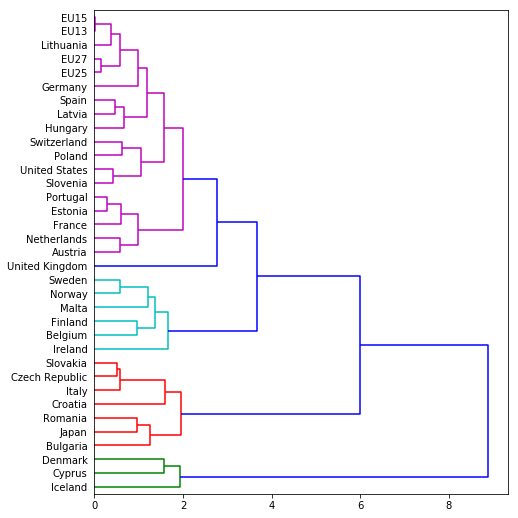

In [76]:
X_train = edudrop.values

dist = pdist(X_train,'euclidean')

linkage_matrix = linkage(dist,method = 'complete');
plt.figure(figsize=(7.3, 7.3))  # we need a tall figure

dendrogram(linkage_matrix, orientation="right", color_threshold = 2,labels = 
           wrk_countries_names, leaf_font_size=10);

plt.tight_layout()  # fixes margins

In scikit-learn, the parameter color_threshold colors all the descendent links below a cluster node k the same color if k is the first node below the color threshold. All links connecting nodes with distances greater than or equal to the threshold are colored blue. Thus, if we use color threshold = 2, the obtained clusters are as follows:

- Cluster 0: ['Cyprus', 'Denmark', 'Iceland']
- Cluster 1: ['Bulgaria', 'Croatia', 'Czech Republic', 'Italy', 'Japan', 'Romania', 'Slovakia']
- Cluster 2: ['Belgium', 'Finland', 'Ireland', 'Malta', 'Norway', 'Sweden']
- Cluster 3: ['Austria', 'Estonia', 'EU13', 'EU15', 'EU25', 'EU27', 'France', 'Germany', 'Hungary', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'Switzerland', 'United Kingdom', 'United States']

Note that they correspond in high degree to the clusters obtained by the K-means (except permutation of clusters labels that is irrelevant). The figure shows the construction of the clusters using the complete linkage agglomerative clustering. Different cuts at different levels of the dendrogram allow to obtain different number of clusters. As a summary, let us compare the results of the three approaches of clustering. We cannot expect that the results coincide since different approaches are based on different criteria to construct the clusters. Still, we can observe that in this case K-means and the agglomerative approaches gave the same results (up to a permutation of the number of cluster that is irrelevant), meanwhile the spectral clustering gave more evenly distributed clusters.  Note that these results can change when using different distance between data.

### Additional examples (Optional)
    

Cluster countries according to the activity rates, gender, and age: './files/laborforce/lfsi_act_a_1_Data.csv'

Sentiment analysis in movies recommendations: Kaggle competition: [When bag of words meets bags of popcorn:](https://www.kaggle.com/c/word2vec-nlp-tutorial)

[Clustering text documents using k-means:](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html)
    

[Visualizing the stock market structure:](http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html)
        


In [78]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

<small><i> This notebook was created by [Petia Radeva](http://www.cvc.uab.es/~petia) and [Oriol Pujol Vila](http://www.maia.ub.es/~oriol). Last edition: 24 of January, 2018.</i></small>